## Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

#### Attribute Information:

   1. Id
   2. ProductId - unique identifier for the product
   3. UserId - unqiue identifier for the user
   4. ProfileName
   5. HelpfulnessNumerator - number of users who found the review helpful
   6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
   7. Score - rating between 1 and 5
   8. Time - timestamp for the review
   9. Summary - brief summary of the review
   10. Text - text of the review

The dataset is available in two forms

   1. .csv file
   2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.


###  Loading the sqlite database and required libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive"

database.sqlite


In [ ]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import os
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

In [6]:
import sqlite3
con = sqlite3.connect('/content/drive/My Drive/database.sqlite')

filtered_data = pd.read_sql_query("""select * from Reviews WHERE Score != 3""",con)

filtered_data.shape
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Partitioning the reviews into positive and negative by the use of score attribute

In [0]:
def partition(x):
    if x < 3:
        return 0
    else:
        return 1

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative


## Data Cleaning : Deduplication

#### There may be same user who has multiple duplicate reviews with the same values of HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text. So, in order to reduce redundancy it was decided to eliminate the rows having same parameters.¶


In [8]:
import datetime

filtered_data["Time"] = filtered_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

sortedData = filtered_data.sort_values('ProductId',axis=0,kind="quicksort", ascending=True)
final = sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

#As data is huge, due to computation limitation we will randomly select data. we will try to pick data in a way so that it doesn't make data imbalance problem
finalp = final[final.Score == 1]
finalp = finalp.sample(frac=0.3,random_state=1)

finaln = final[final.Score == 0]
finaln = finaln.sample(frac=0.8,random_state=1) 

final = pd.concat([finalp,finaln],axis=0)

#sorting data by timestamp so that it can be devided in train and test dataset for time based slicing.
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)


print(final.shape)

(137806, 10)


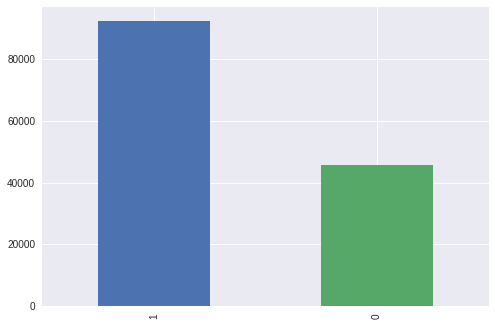

In [9]:
final['Score'].value_counts().plot(kind='bar')

We have taken unbalanced data of unequal number of positive and negative reviews. 

In [0]:
final.sort_values('Time',inplace=True)

## Text Preprocessing: Stemming, stop-word removal and Lemmatization


In [11]:
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



## Feature generation techniques to convert Review texts to numeric vector.

### Bag of Words (BoW) (uni-gram)

###### Splitting Data into Train and Test based on the ascending timestamp of the reviews.


In [0]:
import math
from sklearn import datasets
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = final_string
y = final['Score']

X_train =   final_string[:math.ceil(len(final)*.7)] 
X_test =  final_string[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() 
final_bow_count1 = count_vect.fit_transform(X_train)
final_bow_count2 = count_vect.fit_transform(X_test)

In [0]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler(with_mean=False).fit_transform(final_bow_count1)
X_test = StandardScaler(with_mean=False).transform(final_bow_count2)

In [15]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):

    print(X_train[train].shape, X_train[cv].shape)

(8775, 44784) (8769, 44784)
(17544, 44784) (8769, 44784)
(26313, 44784) (8769, 44784)
(35082, 44784) (8769, 44784)
(43851, 44784) (8769, 44784)
(52620, 44784) (8769, 44784)
(61389, 44784) (8769, 44784)
(70158, 44784) (8769, 44784)
(78927, 44784) (8769, 44784)
(87696, 44784) (8769, 44784)


#### Finding the best "C" value and best regularizer [ L1 or L2 ] using Grid Search CV

In [16]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#parameters we need to find on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) 
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 14.4min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy: 88.10%


#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


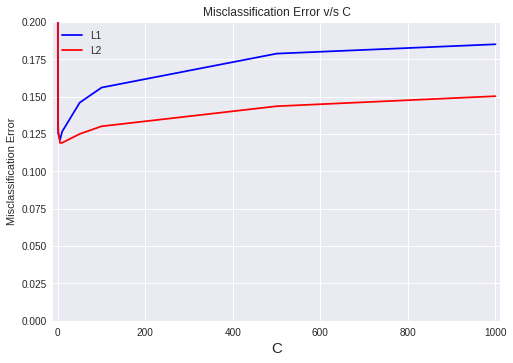

In [17]:
def plot_error_vs_c(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1,y1,'b',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()

plot_error_vs_c(gsv)

Accuracy on test set: 88.462%
Precision on test set: 0.896
Recall on test set: 0.928
F1-Score on test set: 0.911
Non Zero weights: 37473
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



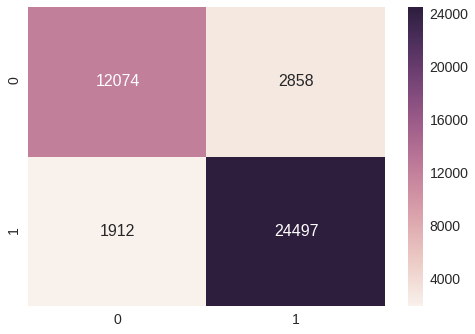

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))

print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


#### Sparsity increases as we increase lambda or decrease C with L1 Regularizer.


In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 83.561%
F1-Score on test set: 0.873
Non Zero weights: 22245


In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.535%
F1-Score on test set: 0.888
Non Zero weights: 16773


In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 87.983%
F1-Score on test set: 0.907
Non Zero weights: 7777


In [22]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.179%
F1-Score on test set: 0.909
Non Zero weights: 1634


In [23]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.610%
F1-Score on test set: 0.891
Non Zero weights: 357


In [24]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 74.906%
F1-Score on test set: 0.828
Non Zero weights: 45


From the above results, we can observe that, the sparsity increases from 22245 non-zero weights(C=1000) to only 45 non-zero weights(C=0.01) with L1 Regularization.

#### Randomized Search CV to find optimal 'C' value and regularization parameters

In [25]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

param_grid = { 'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10)
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.2min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy: 87.49%


Accuracy on test set: 88.479%
Precision on test set: 0.895
Recall on test set: 0.929
F1-Score on test set: 0.912
Non Zero weights: 37473
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



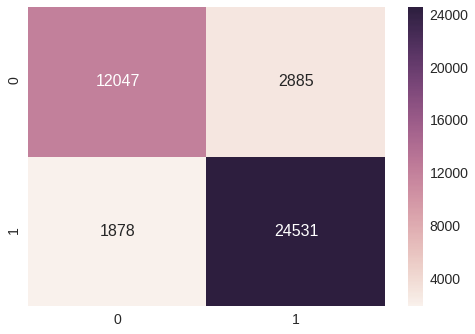

In [37]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


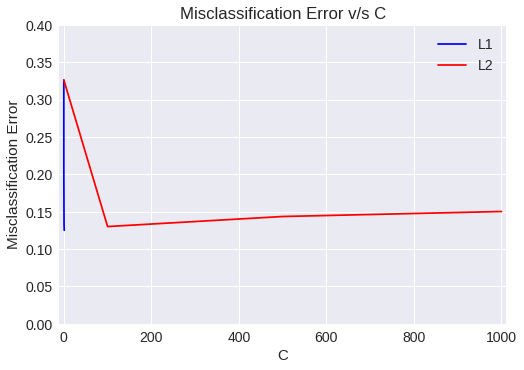

In [38]:

def plot_error_vs_c_r(gsv):
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for a in gsv.grid_scores_:
        if (a[0]['penalty']) == 'l1':
            y1.append(1-a[1])
            x1.append(a[0]['C'])
        else:
            y2.append(1-a[1])
            x2.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    ind2 = np.argsort(x2)
    x2=np.array(x2)
    y2=np.array(y2)
    plt.xlim(-10,1010)
    plt.ylim(0,0.4)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1[ind1],y1[ind1],'b',label="L1")
    plt.plot(x2[ind2],y2[ind2],'r',label="L2")
    plt.legend()
    plt.show()
    
plot_error_vs_c_r(gsv)


### Perturbation Test

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.462%
Non Zero weights: 37473


In [29]:
from scipy.sparse import find
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 6.18756387e-01  1.85705070e-01  1.32426472e-03  2.44996343e-02
  2.19201442e-03  4.17040376e-03 -9.29594140e-02 -3.16261522e-02
  4.17040376e-03  2.98182200e-01  5.38047331e-02  1.06477001e-01
  1.11423945e-01  5.61551667e-02  7.14083267e-04 -9.19048054e-01
 -1.44393910e-02  9.04678786e-02  6.66504302e-01  1.60291777e-02
 -4.27669024e-02  6.58026512e-01 -4.93371207e-01 -6.94667416e-01
  1.82063476e-02 -3.11226436e-01 -8.93647046e-01 -1.76883910e+00
  5.50919893e-02  7.41290549e-01  1.18941298e-01  1.69336398e-02
  4.56255350e-01 -3.65935920e-02 -3.81452653e-01  6.65831215e-01
  6.79501138e-01 -3.36451223e-01 -9.65760203e-01  5.73506171e-01
  1.44319397e+00 -5.45333647e-01 -3.17713929e+00  1.79860621e-01
 -1.55575073e-01  3.23146560e-04  2.98435890e-02  3.65054021e-02
 -4.05435107e-02 -4.17531443e-02]


In [0]:
X_train_t = X_train
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)

X_train_t[a,b] = epsilon + X_train_t[a,b]

In [31]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.462%
Non Zero weights: 37473


In [32]:
from scipy.sparse import find
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 6.18384367e-01  1.85699425e-01  1.32354392e-03  2.45001179e-02
  2.19133399e-03  4.16829954e-03 -9.29766510e-02 -3.16051491e-02
  4.16873058e-03  2.98176807e-01  5.38613477e-02  1.06519685e-01
  1.11380902e-01  5.61559533e-02  7.13261525e-04 -9.19544370e-01
 -1.44285238e-02  9.05129497e-02  6.66587710e-01  1.60567962e-02
 -4.27369828e-02  6.58570306e-01 -4.93864332e-01 -6.95553148e-01
  1.82027619e-02 -3.11046331e-01 -8.93806985e-01 -1.76913175e+00
  5.51225944e-02  7.41374686e-01  1.18919536e-01  1.68892456e-02
  4.56166885e-01 -3.65524851e-02 -3.81493725e-01  6.66120391e-01
  6.79001693e-01 -3.36393293e-01 -9.64686853e-01  5.73520395e-01
  1.44258223e+00 -5.45217667e-01 -3.17779089e+00  1.79694730e-01
 -1.55740987e-01  3.23070245e-04  2.98418197e-02  3.62923799e-02
 -4.04371166e-02 -4.17242405e-02]


In [33]:

print(weights2.size)

37473


In [0]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [35]:
print(weights_diff[np.where(weights_diff > 30)].size)

8



8 features have weight changes greater than 30%. Hence the features are multicollinear

### Top 25 Negative and Positive Features

In [39]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,clf)


			Positive						Negative
________________________________________________________________________________________________
	-14.9845	worst          				9.4047	delici         
	-11.4501	aw             				9.0635	perfect        
	-10.8000	terribl        				8.7681	hook           
	-10.0196	disgust        				8.5961	addict         
	-9.5982	threw          				8.5661	excel          
	-9.2981	disappoint     				8.4470	skeptic        
	-9.1852	tasteless      				8.2187	amaz           
	-9.0768	horribl        				8.1304	yummi          
	-8.5517	unpleas        				8.0051	worri          
	-8.4986	bland          				7.6761	yum            
	-8.4140	gross          				7.5951	beat           
	-7.9951	wors           				7.5800	best           
	-7.9178	yuck           				7.4523	awesom         
	-7.7482	unfortun       				7.2594	fantast        
	-7.5748	return         				7.0864	great          
	-7.5682	flavorless     				7.0315	smooth         
	-7.3902	undrink        				6.6524	uniqu          
	-7.20

### Observation:
1. Features are multi-collinear i.e. they are co-related, by pertubation test.
2. Unigram Featurization performs with accuracy of 88.4% and F1-Score of 0.912
3. Sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

#### Bi-Gram

In [0]:
import math
from sklearn import datasets
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = final_string
y = final['Score']

X_train =   final_string[:math.ceil(len(final)*.7)] 
X_test =  final_string[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range = (1,2))
final_bow_count1 = count_vect.fit_transform(X_train)
final_bow_count2 = count_vect.fit_transform(X_test)

In [0]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler(with_mean=False).fit_transform(final_bow_count1)
X_test = StandardScaler(with_mean=False).transform(final_bow_count2)

#### Finding the best "C" value and best regularizer [ L1 or L2 ] using Grid Search CV

In [49]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#parameters we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.4 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 31.4min finished


Best HyperParameter:  {'C': 50, 'penalty': 'l2'}
Best Accuracy: 89.34%


#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


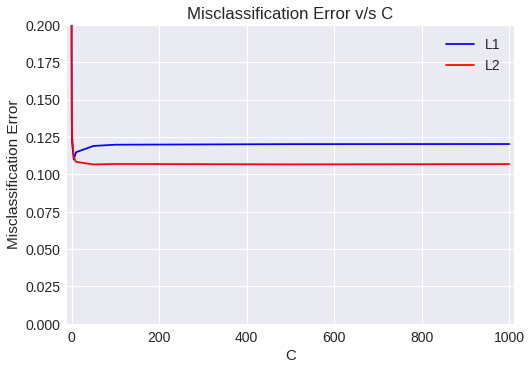

In [50]:
plot_error_vs_c(gsv)

Accuracy on test set: 90.085%
Precision on test set: 0.910
Recall on test set: 0.938
F1-Score on test set: 0.924
Non Zero weights: 1250646
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



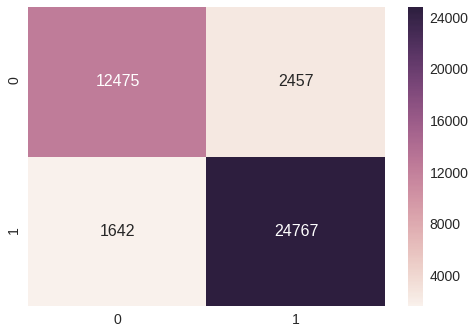

In [51]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [54]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.815%
F1-Score on test set: 0.913
Non Zero weights: 29311


In [55]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.747%
F1-Score on test set: 0.913
Non Zero weights: 22913


In [56]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.432%
F1-Score on test set: 0.918
Non Zero weights: 15518


In [57]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.825%
F1-Score on test set: 0.914
Non Zero weights: 1743


In [58]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 85.095%
F1-Score on test set: 0.888
Non Zero weights: 303


In [59]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 71.735%
F1-Score on test set: 0.812
Non Zero weights: 28


#### Finding the best "C" value and best regularizer [ L1 or L2 ] using Randomized Search CV

In [60]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 13.1 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.7min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 100}
Best Accuracy: 89.31%


#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


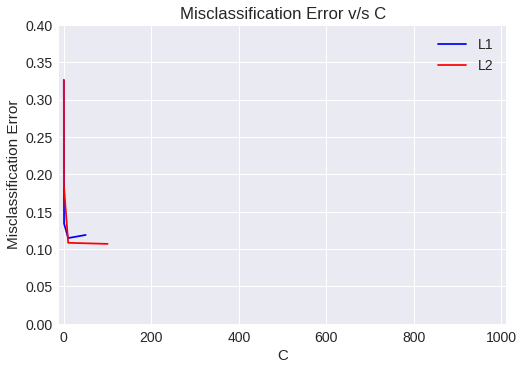

In [61]:
plot_error_vs_c_r(gsv)

Accuracy on test set: 90.085%
Precision on test set: 0.910
Recall on test set: 0.938
F1-Score on test set: 0.924
Non Zero weights: 1250646
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



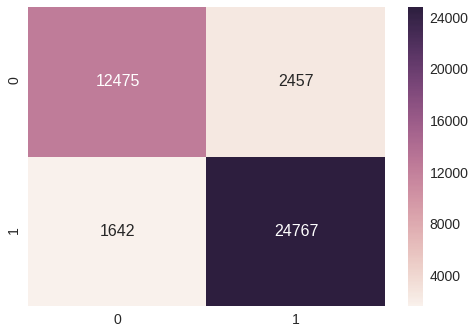

In [62]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Pertubation Test

In [63]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.037%
Non Zero weights: 1250646


In [64]:
from scipy.sparse import find
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 1.13320629e+00  1.13320629e+00  4.79728641e-01 -4.60824873e-02
  4.18514732e-01  7.81002606e-02  2.91961353e-02  3.30969336e-04
  1.68069233e-02  1.68069233e-02  3.48893548e-04  3.48893548e-04
  5.78008060e-03  5.78008060e-03 -1.50927102e-01 -1.50927102e-01
 -1.60335024e-01 -1.60335024e-01  5.78008060e-03  5.78008060e-03
  3.53787276e-01  3.53787276e-01  3.58490436e-02  3.58490436e-02
  1.36945320e-01  1.36945320e-01  2.46038384e-02  2.46038384e-02
  1.26720084e-01  5.18685459e-03  1.21533229e-01  4.03582876e-04
  4.03582876e-04 -9.28132986e-01 -7.82467616e-01 -1.45665370e-01
 -2.71726419e-01  3.99088273e-02  3.99088273e-02 -4.05907264e-01
  1.10667521e-01  8.76730032e-03 -6.50716310e-02  3.06256353e-01
  3.06256353e-01  8.49451111e-01  2.02849055e-03  8.44021881e-01
  3.40073995e-03  1.31064728e-03]


In [0]:
X_train_t = X_train
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)

X_train_t[a,b] = epsilon + X_train_t[a,b]

In [66]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.993%
Non Zero weights: 1250646


In [67]:
from scipy.sparse import find
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 0.28631103  0.28647717  0.08655585 -0.03636776  0.08835174  0.02662309
  0.00790668  0.00042505  0.0179562   0.01795747  0.00047105  0.00047077
  0.00831836  0.00833144 -0.06900018 -0.06921521 -0.03606157 -0.03602566
  0.00833264  0.00832554  0.10866924  0.10863724  0.0247119   0.02475592
  0.04051669  0.0405553   0.01797194  0.01798842  0.05905442  0.00672441
  0.05232335  0.00051224  0.00051259 -0.32714536 -0.17436471 -0.1529727
 -0.0513378   0.01126877  0.01125957 -0.11404006  0.04389227  0.01132912
 -0.01501622  0.08039928  0.08030767  0.24901696  0.00301529  0.24076651
  0.00524678  0.00191099]


In [68]:
print(weights2.size)

1250646


In [0]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [70]:
print(weights_diff[np.where(weights_diff > 30)].size)

634873


### Top 25 Negative and Positive Features

In [71]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bi_gram,clf)

			Positive						Negative
________________________________________________________________________________________________
	-18.4032	worst          				14.9478	high recommend 
	-13.8811	aw             				12.5891	delici         
	-13.7633	terribl        				12.5270	wont disappoint
	-13.0974	disappoint     				11.8830	perfect        
	-13.0468	two star       				10.8539	excel          
	-11.9320	disgust        				10.5499	addict         
	-11.5661	threw          				10.5027	hook           
	-11.5414	horribl        				10.2453	yummi          
	-11.0929	bland          				10.1463	amaz           
	-11.0069	tasteless      				9.8808	even better    
	-10.0707	unpleas        				9.5970	awesom         
	-9.9266	unfortun       				9.5329	best           
	-9.6113	wors           				9.3911	pleasant surpris
	-9.5448	weak           				9.3400	skeptic        
	-9.4133	return         				9.0830	worri          
	-9.3977	gross          				8.9233	yum            
	-9.3932	wont buy       				8.7629	fanta

### Observation:

1. Features are multi-collinear i.e. they are co-related, by pertubation test.
2. Bi-gram Featurization performs with accuracy of 90.08% and F1-Score of 0.924
3. Sparsity increases as we increase lambda or decrease C when L2 Regularizer is used

### Tf-Idf Vectorizer

In [ ]:
import math
from sklearn import datasets
from  sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

X = final_string
y = final['Score']

X_train =   final_string[:math.ceil(len(final)*.7)] 
X_test =  final_string[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [72]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec = TfidfVectorizer()

final_tfidf_count1 = tf_idf_vec.fit_transform(X_train)
final_tfidf_count2 = tf_idf_vec.fit_transform(X_test)


Train Data Size:  (96464, 1250643)
Test Data Size:  (41342, 1250643)
CPU times: user 22.4 s, sys: 156 ms, total: 22.6 s
Wall time: 22.6 s


In [ ]:
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler(with_mean=False).fit_transform(final_tfidf_count1)
X_test = StandardScaler(with_mean=False).transform(final_tfidf_count2)


#### Finding the best "C" value and best regularizer [ L1 or L2 ] using Grid Search CV

In [73]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.9 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 19.8min finished


Best HyperParameter:  {'C': 1000, 'penalty': 'l2'}
Best Accuracy: 89.25%


#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


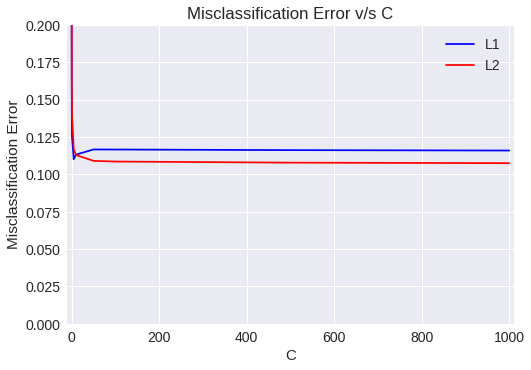

In [74]:
plot_error_vs_c(gsv)

Accuracy on test set: 89.831%
Precision on test set: 0.909
Recall on test set: 0.934
F1-Score on test set: 0.921
Non Zero weights: 11797
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



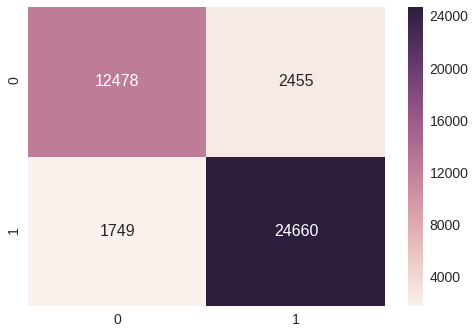

In [75]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [76]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.069%
F1-Score on test set: 0.915
Non Zero weights: 34779


In [77]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 100, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.031%
F1-Score on test set: 0.915
Non Zero weights: 25418


In [78]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.449%
F1-Score on test set: 0.918
Non Zero weights: 17945


In [79]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 88.876%
F1-Score on test set: 0.915
Non Zero weights: 1698


In [80]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.1, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 83.941%
F1-Score on test set: 0.881
Non Zero weights: 218


In [81]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 0.01, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 64.673%
F1-Score on test set: 0.783
Non Zero weights: 6


In [82]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#parameters we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  6.8min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 1000}
Best Accuracy: 89.25%


#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


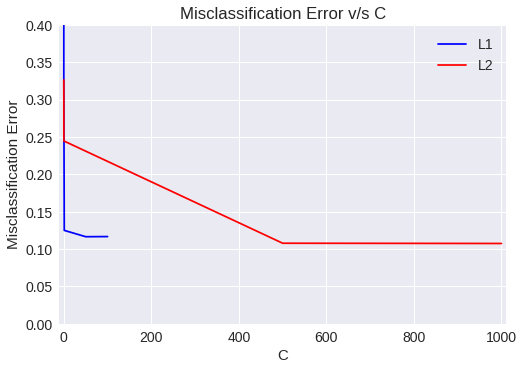

In [83]:
plot_error_vs_c_r(gsv)

Accuracy on test set: 89.826%
Precision on test set: 0.909
Recall on test set: 0.934
F1-Score on test set: 0.921
Non Zero weights: 11791
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



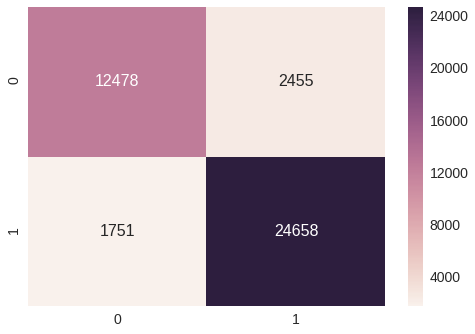

In [84]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l1')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Pertubation Test

In [85]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 500, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 90.158%
Non Zero weights: 1250643


In [86]:
from scipy.sparse import find
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 1.00509466e+00  1.00509466e+00  4.12847310e-01 -1.04698657e-01
  3.78991121e-01  1.31627941e-01  4.17360369e-02  1.54030648e-03
  6.17101063e-02  6.17101063e-02  1.34898674e-03  1.34898674e-03
  2.71839507e-02  2.71839507e-02 -2.57605671e-01 -2.57605671e-01
 -1.65807480e-01 -1.65807480e-01  2.71839507e-02  2.71839507e-02
  4.18748537e-01  4.18748537e-01  7.44057957e-02  7.44057957e-02
  1.27113527e-01  1.27113527e-01  5.18364714e-02  5.18364714e-02
  2.08682727e-01  2.61955744e-02  1.89923535e-01  1.01329639e-03
  1.01329639e-03 -1.04122093e+00 -7.04452770e-01 -3.73871940e-01
 -2.25957462e-01  4.58578204e-02  4.58578204e-02 -3.80843023e-01
  1.00298715e-01  2.04807055e-02 -7.09179389e-02  3.23756603e-01
  3.23756603e-01  7.55308195e-01  6.04529696e-03  7.90075294e-01
  6.39314724e-03  8.66767810e-03]


In [87]:
print(weights1[weights1<=0.0001])

[-0.10469866 -0.25760567 -0.25760567 ... -1.27981651 -0.37295155
 -1.45531383]


In [0]:
X_train_t = X_train
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)

X_train_t[a,b] = epsilon + X_train_t[a,b]

In [89]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 89.998%
Non Zero weights: 1250643


In [90]:
from scipy.sparse import find
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 0.3247902   0.32453978  0.10467456 -0.05971542  0.10591561  0.05071104
  0.01656581  0.00127441  0.05064429  0.05064146  0.00149221  0.0014913
  0.02322372  0.02318837 -0.10417495 -0.10407558 -0.04699218 -0.04678544
  0.02320858  0.02321277  0.15344078  0.15332152  0.04288948  0.04283189
  0.05066988  0.05067962  0.03011144  0.03012415  0.09927833  0.02415531
  0.07864696  0.00111649  0.00111568 -0.42560924 -0.20370867 -0.23700423
 -0.05766986  0.01599901  0.01599103 -0.14146327  0.04944633  0.02400328
 -0.02348244  0.1015225   0.10150575  0.26278739  0.00794138  0.26374202
  0.00752928  0.01213404]


In [91]:
print(weights2.size)

1250643


In [0]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [93]:
print(weights_diff[np.where(weights_diff > 30)].size)

598435


### Top 25 Negative and Positive Features

In [94]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
   
show_most_informative_features(tfidf,clf)  

			Positive						Negative
________________________________________________________________________________________________
	-22.6276	disappoint     				23.3992	great          
	-20.0698	worst          				21.3941	delici         
	-16.4904	terribl        				19.9136	best           
	-15.8294	aw             				18.9423	perfect        
	-13.6649	horribl        				18.8337	love           
	-13.1661	unfortun       				16.6822	high recommend 
	-13.0223	return         				16.1760	excel          
	-12.9197	bland          				13.0896	amaz           
	-12.5763	threw          				13.0640	favorit        
	-12.5523	disgust        				12.9699	good           
	-11.3975	weak           				12.7737	nice           
	-11.0395	tasteless      				12.2593	yummi          
	-11.0028	two star       				12.0459	tasti          
	-10.8574	stale          				12.0045	addict         
	-10.6144	wors           				11.5526	awesom         
	-10.1106	sorri          				10.9957	wont disappoint
	-10.0493	gross          				

### Observation:
1. Features are multi-collinear i.e. they are co-related, by pertubation test.
2. Tf-Idf Featurization performs with accuracy of 89.8% and F1-Score of 0.921
3. Sparsity increases as we increase lambda or decrease C when L1 Regularizer is used

### Average Word2Vec Vectorizer

In [0]:

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [0]:
import gensim
i=0
str1=''
list_of_sent=[]
final_string_for_tfidf = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    str1 = ''
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (cleaned_words.lower() not in stop)):    
                filtered_sentence.append(cleaned_words.lower())
                str1 += " "+cleaned_words.lower() 
            else:
                continue
    
    list_of_sent.append(filtered_sentence)
    final_string_for_tfidf.append((str1).strip())

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

In [0]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [0]:
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split

X = sent_vectors 
y = final['Score']

X_train =  sent_vectors[:math.ceil(len(final)*.7)]  
X_test = sent_vectors[math.ceil(len(final)*.7):] 
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

#### Finding the best "C" value and best regularizer [ L1 or L2 ] using Grid Search CV

In [105]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
#params we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 15.5min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l2'}
Best Accuracy: 85.62%


#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


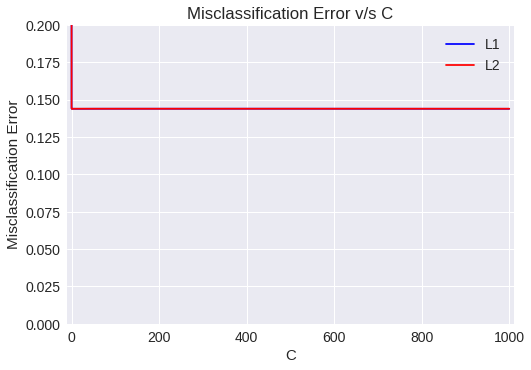

In [106]:
plot_error_vs_c(gsv)

Accuracy on test set: 84.877%
Precision on test set: 0.863
Recall on test set: 0.907
F1-Score on test set: 0.885
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



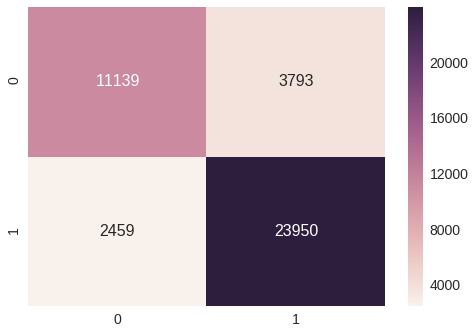

In [107]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 1000, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Finding the best "C" value and best regularizer [ L1 or L2 ] using Randomized Search CV

In [108]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
param_grid = {'C': [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
              ,'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 13.6 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.5min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 1}
Best Accuracy: 85.62%


Accuracy on test set: 84.879%
Precision on test set: 0.863
Recall on test set: 0.907
F1-Score on test set: 0.885
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



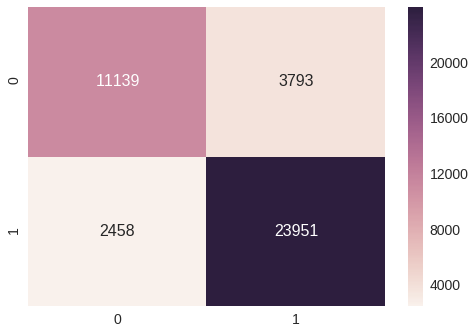

In [109]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


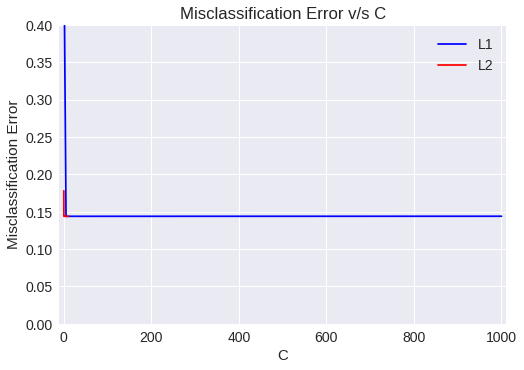

In [110]:

plot_error_vs_c_r(gsv)

In [111]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef))

Accuracy on test set: 84.879%
Non Zero weights: 50


In [112]:
from scipy.sparse import find
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 0.215303   -0.08421248  0.44742257  0.41708556  0.2095311  -0.65949407
  0.01187954  0.3948174   0.94517895  0.58840433  0.21126642 -0.38891501
 -1.23659635  1.64833703  0.1162524  -0.79080296 -0.32443373  0.18665229
 -0.28266221 -0.34966984 -1.05105844 -0.790018   -0.35806312 -0.75572728
  0.10842228 -0.34975354 -0.7637287  -0.12326595  1.01616732 -0.22713083
  0.51885008  0.6682174  -1.08583427  0.20464427  0.74865448  0.80875492
 -0.25958734 -0.41724779 -0.95983595 -0.08332266 -0.31138774  0.55521402
  0.25365556  0.23070857  0.8218135  -0.14952319 -0.53415395  0.38852245
 -0.72455825  0.21369857]


In [0]:
X_train_t = np.array(X_train)
epsilon = np.random.uniform(low=-0.01, high=0.01, size=(find(X_train_t)[0].size,))
a,b,c = find(X_train_t)

X_train_t[a,b] = epsilon + X_train_t[a,b]


In [122]:
#Training on train data having random noise
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 84.872%
Non Zero weights: 50


In [123]:
from scipy.sparse import find
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 0.21305113 -0.08450643  0.4454418   0.42012933  0.21195646 -0.66990876
  0.00706347  0.39263436  0.95061488  0.58739876  0.21259696 -0.38814777
 -1.23410795  1.64547704  0.11539283 -0.78637485 -0.32110015  0.18821724
 -0.28010438 -0.35343375 -1.04767378 -0.78973893 -0.35509688 -0.75313933
  0.10720747 -0.34904896 -0.75995739 -0.12203038  1.00648818 -0.2301609
  0.51872395  0.67144219 -1.08367886  0.20881702  0.74580567  0.80902283
 -0.25966614 -0.41584445 -0.95662743 -0.07436878 -0.3118219   0.56058928
  0.2604125   0.22905283  0.8129459  -0.15396227 -0.53788449  0.39092572
 -0.7186704   0.20852634]


In [124]:
print(weights2.size)

50


In [0]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [126]:
print(weights_diff[np.where(weights_diff > 30)].size)

1


### Observation:
1. Features are multi-collinear i.e. they are co-related, by pertubation test.
2. Avg Word2Vec Featurization performs with accuracy of 84.87% and F1-Score of 0.885
3. Sparsity increases as we increase lambda or decrease C when L2 Regularizer is used

### Tf-Idf Weighted Word2Vec

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vec_w = TfidfVectorizer()

final_tfidf_w = tf_idf_vec_w.fit_transform(final_string_for_tfidf)



In [0]:
tfidf_feat = tf_idf_vec_w.get_feature_names()
tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:  
    sent_vec = np.zeros(50) 
    weight_sum =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tf_idf = final_tfidf_w[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except Exception as e: 
            pass #print(e)
            
    try:
        sent_vec /= weight_sum
    except:
        print(e)
        
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
from sklearn import datasets
X = tfidf_sent_vectors
y = final['Score']

X_train =  tfidf_sent_vectors[:math.ceil(len(final)*.7)] 
X_test = tfidf_sent_vectors[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

#### Finding the best "C" value and best regularizer [ L1 or L2 ] using Grid Search CV

In [130]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit

clf = LogisticRegression()
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 16.8min finished


Best HyperParameter:  {'C': 100, 'penalty': 'l1'}
Best Accuracy: 83.68%


Accuracy on test set: 82.741%
Precision on test set: 0.839
Recall on test set: 0.903
F1-Score on test set: 0.870
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



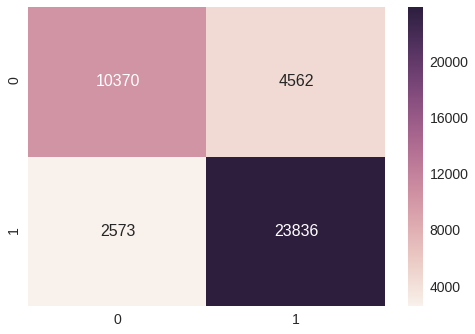

In [131]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


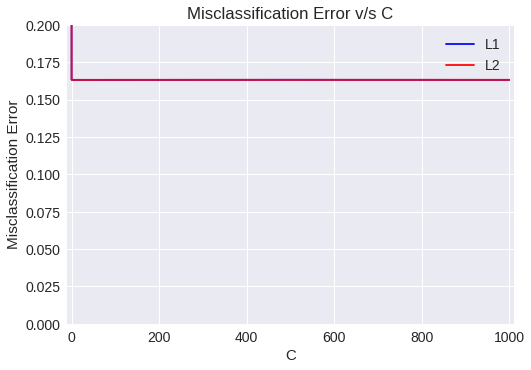

In [132]:
plot_error_vs_c(gsv)


#### Finding the best "C" value and best regularizer [ L1 or L2 ] using  Randomized Search CV

In [133]:
%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
              'penalty':['l1','l2']}
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 13.6 µs
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.1min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1000}
Best Accuracy: 83.68%


#### Function to plot Misclassification error against C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


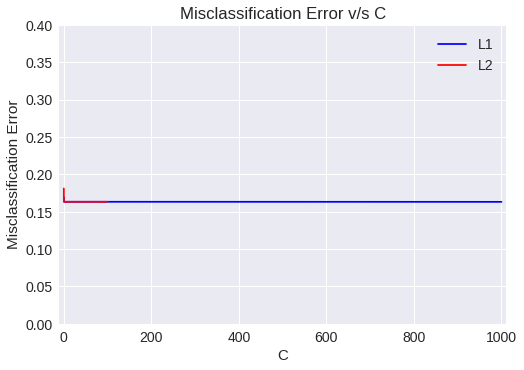

In [134]:
plot_error_vs_c_r(gsv)

Accuracy on test set: 82.739%
Precision on test set: 0.839
Recall on test set: 0.903
F1-Score on test set: 0.870
Non Zero weights: 50
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



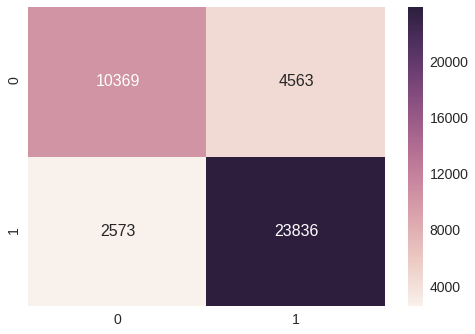

In [135]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(clf.coef_))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [136]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 5, penalty= 'l2')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))

Accuracy on test set: 82.739%
Non Zero weights: 50


In [137]:
from scipy.sparse import find
weights1 = find(clf.coef_[0])[2]
print(weights1[:50])

[ 0.21911647  0.17218338  0.75580931  0.42844329 -0.26931413 -1.12176646
  0.57481188  0.42517511  0.94820462  0.32483445  0.07420206 -0.58757913
 -0.1991115   0.74949686 -0.11049856 -0.31019213 -0.8074204  -0.05553134
 -0.12589457 -0.19398169 -0.5810513  -0.77270143 -0.49608794 -0.09951034
  0.32678439 -0.25988707 -0.15466491  0.00406681  0.74363131  0.13898376
  0.32661956  0.54448773 -0.66445505  0.82079135  0.65918674  0.57539719
  0.22632212  0.42655646 -1.1328619  -0.23919449  0.33666922  0.29416638
  0.00128143  0.00401115  1.24137491  0.02063452 -0.35755433  0.73314468
 -0.66995351 -0.07619673]


In [0]:
X_train_t = np.array(X_train)
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size))
a,b,c = find(X_train_t)

X_train_t[a,b] = epsilon + X_train_t[a,b]

In [139]:
#Predicting the output of test data.

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C= 10, penalty= 'l2')
clf.fit(X_train_t,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(clf.coef_))


Accuracy on test set: 82.741%
Non Zero weights: 50


In [140]:
from scipy.sparse import find
weights2 = find(clf.coef_[0])[2]
print(weights2[:50])

[ 2.19181207e-01  1.72268796e-01  7.55960576e-01  4.28385986e-01
 -2.69361810e-01 -1.12157372e+00  5.74986489e-01  4.25271931e-01
  9.48168166e-01  3.24854422e-01  7.41520897e-02 -5.87808407e-01
 -1.99238164e-01  7.49595281e-01 -1.10491953e-01 -3.10318102e-01
 -8.07523748e-01 -5.56602047e-02 -1.25927340e-01 -1.93797580e-01
 -5.81178723e-01 -7.72786963e-01 -4.96357681e-01 -9.95965285e-02
  3.26920260e-01 -2.59921006e-01 -1.54812360e-01  4.09310942e-03
  7.43914903e-01  1.39119980e-01  3.26737282e-01  5.44391545e-01
 -6.64578232e-01  8.20674374e-01  6.59308959e-01  5.75473756e-01
  2.26357821e-01  4.26562683e-01 -1.13299444e+00 -2.39380697e-01
  3.36644078e-01  2.94034129e-01  1.07775941e-03  4.02741419e-03
  1.24181665e+00  2.08053424e-02 -3.57477032e-01  7.33176804e-01
 -6.70202583e-01 -7.59805053e-02]


In [144]:
print(weights2.size)

50


In [0]:
weights_diff = (abs(weights2 - weights1)/weights1) * 100

In [146]:
print(weights_diff[np.where(weights_diff > 30)].size)

0


### Observation:

1. Tf-Idf weighted Word2Vec Featurization performs with accuracy of 82.73% and F1-Score of 0.870.
2. Sparsity increases as we increase lambda or decrease C when L2 Regularizer is used.
3. Bigram Featurization performs best of all featurization techniques with accuracy of 90.08% and F1-Score of 0.924.
4. Logistic Regression works efficiently, on application on text data.